# Chapter 4
# Finite-Dimensional Optimization

In this chapter we examine methods for optimizing a function with respect to a finite
number of variables. In the finite-dimensional optimization problem, one is given a
real-valued function $f$ defined on $X \subset R^n$ and asked to find an $x^* \in X$ such that
$f(x^*) \geq f(x)$ for all $x \in X$. We denote this problem

$$\max_{x \in X} f(x)$$

and call $f$ the objective function, $X$ the feasible set, and $x^*$, if it exists, a maximum.

There is a close relationship between the finite-dimensional optimization problems
discussed in this chapter and the rootfinding and complementarity problems
discussed in the previous chapter. The first-order necessary conditions of an unconstrained
problem pose a rootfinding problem; the Karush-Kuhn-Tucker first-order
necessary conditions of a constrained optimization problem pose a complementarity
problem. The rootfinding and complementarity problems associated with optimization
problems are special in that they possess a natural merit function, the objective
function itself, which may be used to determine whether iterations are converging on
a solution.

Over the years, numerical analysts have studied finite-dimensional optimization
problems extensively and have devised a variety of algorithms for solving them quickly
and accurately. We begin our discussion with derivative-free methods, which are useful
if the objective function is rough or if its derivatives are expensive to compute.
We then turn to Newton-type methods for unconstrained optimization, which employ
derivatives or derivative estimates to locate an optimum. Univariate unconstrained
optimization methods are of particular interest because many multivariate optimization
algorithms use the strategy of first determining a linear direction to move in,
and then finding the optimal point in that direction. We conclude with a discussion
of how to solve constrained optimization problems.

## 4.1 Derivative-Free Methods

As was the case with univariate rootfinding, optimization algorithms exist that will
place progressively smaller brackets around a local maximum of a univariate function.
Such methods are relatively slow, but do not require the evaluation of function
derivatives and are guaranteed to find a local optimum to a prescribed tolerance in a
known number of steps.

The most widely-used derivative-free method is the **golden search** method.

Suppose
we wish to find a local maximum of a continuous univariate function $f(x)$ on
the interval $[a; b]$. Pick any two numbers in the interior of the interval, say $x_1$ and $x_2$
with $x_1 < x_2$. Evaluate the function and replace the original interval with $[a; x2]$ if
$f(x_1) > f(x_2)$ or with $[x_1; b]$ if $f(x_2) \geq f(x_1)$.

A key issue is how to pick the interior evaluation points. Two simple criteria lead
to the most widely-used strategy. First, the length of the new interval should be
independent of whether the upper or lower bound is replaced. Second, on successive
iterations, one should be able to reuse an interior point from the previous iteration so
that only one new function evaluation is performed per iteration. These conditions
are uniquely satisfied by selecting $x_i = a + \alpha_i (b - a)$, where

$$\alpha_1 = \frac{3-\sqrt 5}{2}$$

$$\alpha_2 = \frac{\sqrt 5 -1}{2}$$

The value $\alpha_2$ is known as the golden ratio, a number dear to the hearts of Greek
philosophers and Renaissance artists.

In [111]:
import numpy as np
from numpy import append, array, diagonal, tril, triu
from numpy.linalg import inv
from scipy.linalg import lu
#from scipy.linalg import solve
from pprint import pprint
from numpy import array, zeros, diag, diagflat, dot

from sympy import *
import sympy as sym
init_printing()

In [112]:
%matplotlib notebook
from matplotlib import pyplot as plt

In [113]:
maxit = 1000
tol = 1/10000
x0= np.array([0,3])
f = lambda x: x * np.cos(x ** 2)

a,b = 0,3

<IPython.core.display.Javascript object>


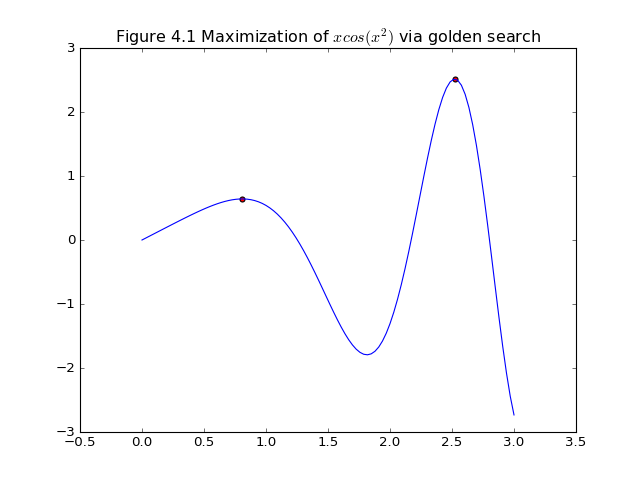

In [114]:
x = np.linspace(0,3, 100)
y = f(x)
plt.plot(x,y)
plt.scatter( np.array([0.8083,2.5234]), f(np.array([0.8083,2.5234])) , c='r' )
plt.title("Figure 4.1 Maximization of $x cos(x^2)$ via golden search")

In [115]:
alpha1 = (3 - np.sqrt(5)) / 2
alpha2 = (np.sqrt(5) - 1) / 2
if a > b:
    a, b = b, a

x1 = a + alpha1 * (b - a)
x2 = a + alpha2 * (b - a)

f1, f2 = f(x1), f(x2)

d = (alpha1 * alpha2)*(b - a)

In [116]:
while d > tol:
    d = d * alpha2
    if f2 < f1: # x2 is new upper bound
        x2, x1 = x1, x1 - d
        f2, f1 = f1, f(x1)
    else:  # x1 is new lower bound
        x1, x2 = x2, x2 + d
        f1, f2 = f2, f(x2)

In [117]:
#x1 if f1 > f2 else x2

In [118]:
if f1>f2:
    x = x2
else:
    x = x1      
x    

In [119]:
def mygolden(f,a, b, maxit = 1000, tol = 1/10000):
    alpha1 = (3 - np.sqrt(5)) / 2
    alpha2 = (np.sqrt(5) - 1) / 2
    if a > b:
        a, b = b, a
        
    x1 = a + alpha1 * (b - a)
    x2 = a + alpha2 * (b - a)

    f1, f2 = f(x1), f(x2)

    d = (alpha1 * alpha2)*(b - a) # initial d
    while d > tol:
        d = d * alpha2 # alpha2 is the golden ratio
        if f2 < f1: # x2 is new upper bound
            x2, x1 = x1, x1 - d
            f2, f1 = f1, f(x1)
        else:  # x1 is new lower bound
            x1, x2 = x2, x2 + d
            f1, f2 = f2, f(x2)
            
    if f1>f2:
        x = x2
    else:
        x = x1      
    return x    

In [120]:
mygolden(f, 0, 3)

Execution of this script yields the result $x = 0.8083$. As can be seen in Figure 4.1,
this point is a local maximum, but not a global maximum in $[0; 3]$. The golden search
method is guaranteed to find the global maximum when the function is concave.
However, as the present example makes clear, this need not be true when the optimand
is not concave.

## Nelder-Mead algorithm

Another widely-used derivative-free optimization method for multivariate functions
is the **Nelder-Mead algorithm**.

The Nelder-Mead algorithm is simple, but slow and unreliable. However, if a
problem involves only a single optimization or costly function and derivative evaluations,
the Nelder-Mead algorithm is worth trying. In many problems an optimization
problem that is embedded in a larger problem must be solved repeatedly, with the
function parameters perturbed slightly with each iteration. For such problems, which
are common is dynamic models, one generally will want to use a method that moves
more quickly and reliably to the optimum, given a good starting point.


(source: https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method)


The Nelder–Mead method or downhill simplex method or amoeba method is a commonly applied numerical method used to find the minimum or maximum of an objective function in a multidimensional space. It is applied to nonlinear optimization problems for which derivatives may not be known. However, the Nelder–Mead technique is a heuristic search method that can converge to non-stationary points[1] on problems that can be solved by alternative methods.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e4/Nelder-Mead_Rosenbrock.gif/640px-Nelder-Mead_Rosenbrock.gif)

(source: http://www.scholarpedia.org/article/Nelder-Mead_algorithm)

The Nelder-Mead algorithm or simplex search algorithm, originally published in 1965 (Nelder and Mead, 1965), is one of the best known algorithms for multidimensional unconstrained optimization without derivatives. This method should not be confused with Dantzig's simplex method for linear programming, which is completely different, as it solves a linearly constrained linear problem.

The basic algorithm is quite simple to understand and very easy to use. For these reasons, it is very popular in many fields of science and technology, especially in chemistry and medicine.

The method does not require any derivative information, which makes it suitable for problems with non-smooth functions. It is widely used to solve parameter estimation and similar statistical problems, where the function values are uncertain or subject to noise. It can also be used for problems with discontinuous functions, which occur frequently in statistics and experimental mathematics.

In [121]:
#https://github.com/fchollet/nelder-mead/blob/master/nelder_mead.py

'''
    Pure Python/Numpy implementation of the Nelder-Mead algorithm.
    Reference: https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method
'''
import copy

def nelder_mead(f, x_start,
                step=0.1, no_improve_thr=10e-6,
                no_improv_break=10, max_iter=0,
                alpha=1., gamma=2., rho=-0.5, sigma=0.5):
    '''
    @param f (function): function to optimize, must return a scalar score
        and operate over a numpy array of the same dimensions as x_start
    @param x_start (numpy array): initial position
    @param step (float): look-around radius in initial step
    @no_improv_thr,  no_improv_break (float, int): break after no_improv_break iterations with
        an improvement lower than no_improv_thr
    @max_iter (int): always break after this number of iterations.
        Set it to 0 to loop indefinitely.
    @alpha, gamma, rho, sigma (floats): parameters of the algorithm
        (see Wikipedia page for reference)
    return: tuple (best parameter array, best score)
    '''
    # init
    dim = len(x_start)
    prev_best = f(x_start)
    no_improv = 0
    res = [[x_start, prev_best]]

    for i in range(dim):
        x = copy.copy(x_start)
        x[i] = x[i] + step
        score = f(x)
        res.append([x, score])

    # simplex iter
    iters = 0
    while 1:
        # order
        res.sort(key=lambda x: x[1])
        best = res[0][1]

        # break after max_iter
        if max_iter and iters >= max_iter:
            return res[0]
        iters += 1

        # break after no_improv_break iterations with no improvement
        print('...best so far:', best)

        if best < prev_best - no_improve_thr:
            no_improv = 0
            prev_best = best
        else:
            no_improv += 1

        if no_improv >= no_improv_break:
            return res[0]

        # centroid
        x0 = [0.] * dim
        for tup in res[:-1]:
            for i, c in enumerate(tup[0]):
                x0[i] += c / (len(res)-1)

        # reflection
        xr = x0 + alpha*(x0 - res[-1][0])
        rscore = f(xr)
        if res[0][1] <= rscore < res[-2][1]:
            del res[-1]
            res.append([xr, rscore])
            continue

        # expansion
        if rscore < res[0][1]:
            xe = x0 + gamma*(x0 - res[-1][0])
            escore = f(xe)
            if escore < rscore:
                del res[-1]
                res.append([xe, escore])
                continue
            else:
                del res[-1]
                res.append([xr, rscore])
                continue

        # contraction
        xc = x0 + rho*(x0 - res[-1][0])
        cscore = f(xc)
        if cscore < res[-1][1]:
            del res[-1]
            res.append([xc, cscore])
            continue

        # reduction
        x1 = res[0][0]
        nres = []
        for tup in res:
            redx = x1 + sigma*(tup[0] - x1)
            score = f(redx)
            nres.append([redx, score])
        res = nres



In [122]:
import math
import numpy as np

# def f(x):
#     return math.sin(x[0]) * math.cos(x[1]) * (1. / (abs(x[2]) + 1))

#f(x,y) = x^2 - 4*x + y^2 - y - x*y;
# f = lambda x: x[0]**2- 4*x[0] + x[1]**2- x[1] - x[0]*x[1]


def f(x):
    return x[0]**2- 4*x[0] + x[1]**2- x[1] - x[0]*x[1]

In [123]:
nelder_mead(f, np.array([0., 0.]))

...best so far: -0.39
...best so far: -0.7275
...best so far: -1.393125
...best so far: -2.35265625
...best so far: -3.5309765625
...best so far: -5.22336914063
...best so far: -5.22336914063
...best so far: -5.4678515625
...best so far: -6.54388916016
...best so far: -6.54388916016
...best so far: -6.79
...best so far: -6.79
...best so far: -6.82644058228
...best so far: -6.89778457642
...best so far: -6.94423038483
...best so far: -6.98128607035
...best so far: -6.98128607035
...best so far: -6.99655470744
...best so far: -6.99655470744
...best so far: -6.99655470744
...best so far: -6.99880626416
...best so far: -6.99950646219
...best so far: -6.99950646219
...best so far: -6.99972928513
...best so far: -6.99991771801
...best so far: -6.99995652906
...best so far: -6.99995652906
...best so far: -6.99998705445
...best so far: -6.99999239547
...best so far: -6.99999584097
...best so far: -6.99999751173
...best so far: -6.99999837535
...best so far: -6.99999975505
...best so far: -6.99

[array([ 2.99996614,  2.00000911]), -6.9999999984625303]

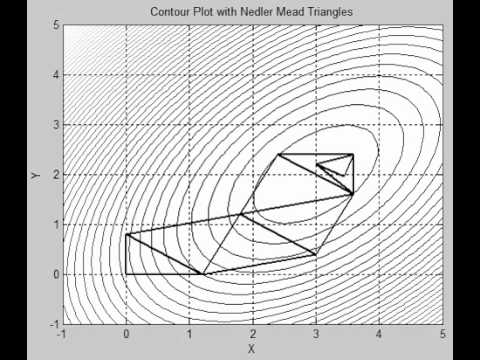

In [124]:
#https://codesachin.wordpress.com/2016/01/16/nelder-mead-optimization/
from IPython.display import YouTubeVideo
# Evaluates the function:
# f(x,y) = x^2 - 4*x + y^2 - y - x*y;
YouTubeVideo("HUqLxHfxWqU")

##### Scipy implementation


http://www.scipy-lectures.org/advanced/mathematical_optimization/

In scipy, scipy.optimize.fmin() implements the Nelder-Mead approach:

In [125]:
from scipy import optimize

optimize.fmin(f, [2, 2])

Optimization terminated successfully.
         Current function value: -7.000000
         Iterations: 40
         Function evaluations: 73


array([ 2.99998082,  2.00001514])

https://docs.scipy.org/doc/scipy/reference/optimize.minimize-neldermead.html


In [126]:
optimize.minimize(f, [2, 2],method='Nelder-Mead')

 final_simplex: (array([[ 2.99998082,  2.00001514],
       [ 2.9999984 ,  1.99993767],
       [ 2.99993967,  1.99992527]]), array([-7., -7., -7.]))
           fun: -6.9999999991122497
       message: 'Optimization terminated successfully.'
          nfev: 73
           nit: 40
        status: 0
       success: True
             x: array([ 2.99998082,  2.00001514])

## 4.2 Newton-Raphson Method

banana " f = ('-100*(x(2)-x(1)^2)^2-(1-x(1))^2')", so-called because its contours resemble bananas.

<IPython.core.display.Javascript object>


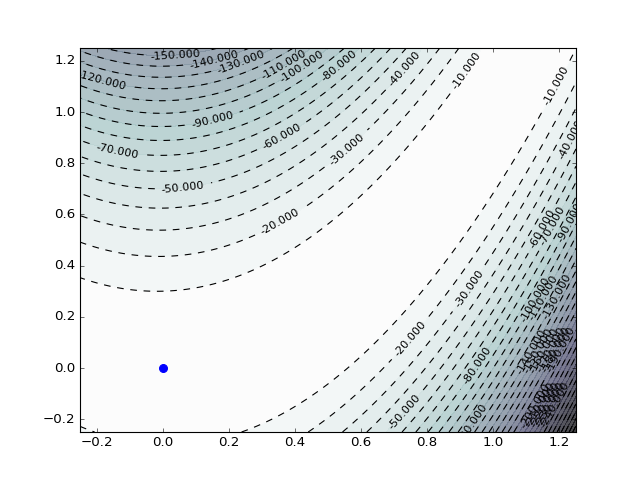

In [127]:
f = lambda x,y:(-100*(y-x**2)**2-(1-x)**2)

# def f(x,y):
#     # the height function
#     return (1 - x / 2 + x**5 + y**3) * np.exp(-x**2 -y**2)

n = 256
x = np.linspace(-0.25, 1.25, n)
y = np.linspace(-0.25, 1.25, n)
X,Y = np.meshgrid(x, y) 

plt.figure()
x0,y0 = 0,0
# use plt.contourf to filling contours
# X, Y and value for (X,Y) point
plt.contourf(X, Y, f(X, Y), 38, alpha=.75,cmap='bone')# cmap=plt.cm.hot)

# use plt.contour to add contour lines
C = plt.contour(X, Y, f(X, Y), 38, colors='black', linewidth=.5)

plt.clabel(C, inline=True, fontsize=10)
# plt.xticks(())
# plt.yticks(())

# set dot styles
plt.scatter([x0, ], [y0, ], s=50, color='b')



plt.xlim(-0.25, 1.25)
plt.ylim(-0.25, 1.25)

The Newton-Raphson method for maximizing an objective function uses successive
quadratic approximations to the objective in the hope that the maxima of the approximants
will converge to the maximum of the objective. The Newton-Raphson
method is intimately related to the Newton method for solving rootfinding problems.

Indeed, the Newton-Raphson method is identical to applying Newton's method to
compute the root of the gradient of the objective function.

The Taylor series of $f(x)$ about the point  $x=x_0 + \epsilon$ is given by

$$f(x_0 + \epsilon) = f(x_0)+ f'(x_0) \epsilon +\frac{1}{2} f''(x_0) \epsilon^2 $$

$$f(x) = f(x^{(k)})+ f'(x^{(k)}) (x-x^{(k)}) + \frac{1}{2}(x-x^{(k)})^T  f''(x^{(k)}) (x-x^{(k)}) $$

Solving the first order condition

$$f'(x^{(k)})+ f''(x^{(k)}) (x-x^{(k)}) = 0$$

yields the iteration rule



$$x^{(k+1)} \leftarrow x^{(k)} -  [f''(x^{(k)})]^{-1} f'(x^{(k)}) $$

In theory, the Newton-Raphson method converges if $f$ is twice continuously difierentiable
and if the initial value of x supplied by the analyst is sufficiently close to a
local maximum of $f$ at which the **Hessian $f''$** is negative definite. There is, however,
no generally practical formula for determining what sufficiently close is.

The Newton-Raphson method can be robust to the starting
value if $f$ is well behaved, for example, if f is **globally concave**. The Newton-Raphson
method, however, can be very sensitive to starting value if the function is not globally
concave. Also, in practice, the **Hessian $f''$**  must be well-conditioned at the optimum,
otherwise rounding errors in the vicinity of the optimum can make it difficult to
compute a precise approximate solution.

The Newton-Raphson algorithm has numerous drawbacks. 

First, the algorithm
requires computation of both the first and second derivatives of the objective function.


Second, the Newton-Raphson algorithm offers no **guarantee** that the objective function
value may be increased in the direction of the Newton step. Such a guarantee is
available only if the Hessian **Hessian $f''(x^k)$** is **negative definite**; otherwise, one may actually
move towards a saddle point of f (if the Hessian is indefinite) or even a minimum (if
Hessian is **positive definite**).

For this reason, the Newton-Raphson method is rarely
used in practice, and then only if the objective function is **globally concave**.

## 4.3 Quasi-Newton Methods


Quasi-Newton methods employ a similar strategy to the Newton-Raphson method,
but **replace the Hessian of the objective function (or its inverse) with a negative
definite approximation, guaranteeing that function value can be increased in the direction
of the Newton step**. 

The most efficient quasi-Newton algorithms employ an
approximation to the inverse Hessian, rather than the Hessian itself, in order to avoid
performing a linear solve, and employ updating rules that do **not require second
derivative information** to ease the burden of implementation and the cost of computation.

In analogy with the Newton-Raphson method, quasi-Newton methods use a search
direction of the form

$$d^{(k)} = -B^{(k)} f'(x^{(k)})$$

where $B^{(k)}$ is an approximation to the **inverse Hessian** of f at the kth iterate $x^{(k)}$.
The vector $d^{(k)}$ is called the **Newton or quasi-Newton step**.

The more robust quasi-Newton methods do not necessarily take the full Newton
step, but rather shorten it or lengthen it in order to obtain improvement in the
objective function. This is accomplished by performing a line-search in which one
seeks a **step length $s > 0$** that maximizes or nearly maximizes $f (x^{(k)} + sd^{(k)})$. Given
the computed step length $s^{(k)}$, one updates the iterate as follows:

$$x^{(k+1)}=  x^{(k)} + s^{(k)}  d^{(k)}$$

Quasi-Newton method differ in how the inverse Hessian approximation Bk is constructed
and updated. The simplest quasi-Newton method sets

$$B^{(k)} = - I $$, 

where I is  the identity matrix. This leads to a Newton step that is identical to the gradient of
the objective function at the current iterate:


$$d^{(k)} = f'(x^{(k)})$$

The choice of gradient as a step direction is intuitively appealing because the gradient
always points in the direction which, to a first order, promises the greatest increase in
f. For this reason, this quasi-Newton method is called the method of *steepest ascent.*'


The steepest ascent method is simple to implement, but is numerically *less efiicient*
in practice than competing quasi-Newton methods that *incorporate* information regarding
the **curvature of the objective function**.
 


The **most widely-used** quasi-Newton methods that employ **curvature information**
produce a sequence of inverse Hessian estimates that satisfy two conditions. 

**First,**
given that


$$d^{(k)} \approx f''^{-1}(x^{(k)})( f'(x^{(k)}+ d^{(k)} ) - f'(x^{(k)})  )$$

the **inverse Hessian estimate** $A^{(-k)}$ is required to satisfy the so-called **quasi-Newton condition:**

$$d^{(k)} = B^{(k)} (x^{(k)})( f'(x^{(k)}+ d^{(k)} ) - f'(x^{(k)})  )$$

**Second,** the inverse Hessian estimate $A^{(-k)}$  is required to be both **symmetric and
negative-definite**, as must be true of the inverse Hessian at a local maximum. The
negative definiteness of the Hessian estimate assures that the objective function value
can be inreased in the **direction of the Newton step**.


Two methods that satisfy the quasi-Newton and negative definiteness conditions
are the Davidson-Fletcher-Powell (DFP) and **Broyden-Fletcher-Goldfarb-Shano (BFGS)**
updating methods. The DFP method uses the updating scheme


$$B \leftarrow B + \frac{d d^T}{d^T u}  - \frac{B u u^T B}{u^T B u} $$


where

$$d = x^{(k+1)} - x^{(k)}$$

and 

$$u = f'(x^{(k+1)}) - f'(x^{(k)})$$

The BFGS method uses the update scheme


$$B \leftarrow B + \frac{1}{d^T u}( w d^T + d w^T  - \frac{w^T u}{d^T u}) d d^T $$

where 

$$w = d - B u$$



The BFGS algorithm is generally considered superior to DFP, although there
are problems for which DFP outperforms BFGS. However, except for the updating
formulae, the two methods are identical, so it is easy to implement both and give
users the choice.

In [233]:
errcode = False
def optstep(stepmeth,func, x0, fx0, g0, d, maxstep = 1000):
    # take multiple output of function
    A = func(x)
    _is_there_jacobian = (type(A) is tuple) and (len(A) == 2)

    if _is_there_jacobian:
        #print('Jacobian was provided by user!')
        f = lambda z:  func(z)[0]

    
    
    
    # several step search method
    def _step_none(f, x0, fx0, d,maxstep):
        fx = f(x0 + d)
        if fx < fx0:
            s = 1
            errcode = False
            return s, f
        else:
            return _step_golden(f, x0, fx0, d,maxstep)

    def _step_bhhh(f, x0, fx0, g0, d,maxstep):
        # Intializations
        delta = 0.0001
        dg = -np.inner(g0, d)  # directional derivative
        tol1 = dg * delta
        tol0 = dg * (1 - delta)
        s, ds = 1, 1
        errcode = False

        # Bracket the cone
        for it in range(maxstep):
            x = x0 + s * d
            fs = f(x)
            temp = (fx0 - fs) / s
            if temp < tol0:
                ds *= 2
                s += ds
            else:
                break

        if (tol0 <= temp) and (temp <=tol1):
            return s, fs

        ds /= 2
        s -= ds
        it0 = it + 1

        # Then use bisection to get inside it
        for it in range(it0, maxstep):
            ds /= 2
            x = x0 + s * d
            fs =  f(x)
            temp = (fx0 - fs) / s
            if temp > tol1:
                s -= ds
            elif temp < tol0:
                s += ds
            else:
                return s, fs

        # If it has not returned yet, call _step_golden!
        return _step_golden(f, x0, fx0, d, maxstep)

    def _step_bt(f, x0, fx0, g0, d, maxstep):
        delta = 1e-4 # Defines cone of convergence; must be on (0,1/2)
        ub = 0.5     # Upper bound on acceptable reduction in s.
        lb = 0.1     # Lower bound on acceptable reduction in s.
        errcode = 0
        dg = -np.inner(d, g0)  # directional derivative
        tol1 = delta * dg
        tol0 = (1 - delta) * dg

        # full step
        s = 1
        fs = f(x0+d)
        if (fx0 - fs)   <= tol1:
            return s, fs

        # quadratic approximation
        s2, fs2 = s, fs
        s = -0.5 * dg / (-fs + fx0 - dg)
        s = max(s, lb)
        fs = f(x0 + s * d)
        temp = (-fs + fx0) / s
        if (tol0 <= temp) and (temp <= tol1):
            return s, fs

        # cubic approximation
        for it in range(3, maxstep):
            temp = (s - s2) * np.array([s * s, s2 * s2])
            temp = np.array([- fs + fx0 - dg * s, -fs2 + fx0 - dg * s2]) / temp
            a = temp[0] - temp[1]
            b = s * temp[1] - s2 * temp[0]
            s2 = s
            fs2 = fs
            if np.all(a == 0):  # quadratic fits exactly
                s = -0.5 * dg / b
            else:
                disc = b * b - 3 * a * dg
                if np.all(disc < 0):
                    errcode = 2
                    return s, fs  # complex root
                s = (np.sqrt(disc) - b) / (3 * a)

            s = np.maximum(np.minimum(s, ub * s2), lb * s2)  # ensures acceptable step size; cp(f, lb, up)
            fs = f(x0 + s * d)
            temp = (-fs + fx0) / s
            if np.all(tol0 <= temp) and np.all(temp <= tol1):
                return s, fs

        # If it has not returned yet, call _step_golden instead
        return _step_golden(f, x0, fx0, d,maxstep)

    def _step_golden(f, x0, fx0, d,maxstep):
        alpha1 = (3 - np.sqrt(5)) / 2
        alpha2 = (np.sqrt(5) - 1) / 2
        tol = 1.e-4
        tol *= alpha1*alpha2
        s = 1
        errcode = True
        niter = 0
        s0 = 0
        it = 0

        # Find a bracketing interval
        fs = f(x0 + d)
        if fx0 >= fs:
            lenght = alpha1
        else:
            for it in range(maxstep):
                s *= 2
                fl = fs
                fs = f(x0 + s*d)
                if fs <=fl:
                    lenght = alpha1 * (s - s0)
                    break
                else:
                    s0 /= 2

            if (it + 1) >= maxstep:
                s /= 2
                fs = fl
                return s, fs

        xl = x0 + (s + lenght) * d
        xs = x0 + (s - lenght) * d

        s -= lenght
        lenght *= alpha2  # lenght now measures relative distance between xl and xs

        fs = f(xs)
        fl = f(xl)

        # Golden search to find minimum
        while it < maxstep:
            it += 1
            if fs < fl:
                s -= lenght
                lenght *= alpha2
                xs = xl
                xl -= lenght * d
                fs = fl
                fl = f(xl)
            else:
                lenght *= alpha2
                s += lenght
                xl = xs
                xs += lenght * d
                fl = fs
                fs = f(xs)

            if lenght < tol:
                errcode = False
                break
        if fl > fs:
            fs = fl
            s -= lenght
        return s, fs
    
    # return resulted s and fx
    if stepmeth == None:
        return _step_none(f, x0, fx0, d,maxstep)
    elif stepmeth == "bhhh":
        return _step_bhhh(f, x0, fx0, g0, d,maxstep)
    elif stepmeth == "bt":
        return _step_bt(f, x0, fx0, g0, d,maxstep)
    elif stepmeth == "golden":
        return _step_golden(f, x0, fx0, d,maxstep)
        
    
    

In [234]:
s, fx = optstep("golden" ,f, x, fx0, g0, d, maxstep)

In [235]:
s,fx

The script assumes that the user
has written a Python routine f that evaluates the function at an arbitrary point and
that the user has specified a starting point x, an initial guess for the inverse Hessian
A, a convergence tolerance tol, and a limit on the number of iterations maxit. The
script uses an auxiliary algorithm optstep to determine the step length (discussed
in the next section). The algorithm also offers the user a choice on how to select the
search direction, searchmeth (1-steepest ascent, 2-DFP, 3-BFGS).

https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html

In [179]:
        # self.step_methods = {'none': self._step_none,
        #                      'bhhh': self._step_bhhh,
        #                      'bt': self._step_bt,
        #                      'golden': self._step_golden
        #                      }
        # self.search_methods = {'steepest': self._search_steepest,
        #                        'bfgs': self._search_bfgs,
        #                        'dfp': self._search_dfp
        #                        }

In [237]:
step_methods = ['none','bhhh','bt','golden']                         
search_methods = ['steepest','dfp','bfgs']                           

In [180]:
#         if self.x0 is None or self.x0[0] is None:
#             raise ValueError('Initial value is required to solve a OP, none provided!')

In [181]:
def f(x):
    y = (-100*(x[1]-x[0]**2)**2-(1-x[0])**2)
    dy = np.array([2*(1-x[0])+400*(x[1]-x[0]**2)*x[0],  -200*(x[1]-x[0]**2)])
    return y,dy

In [261]:
x_list = list()# last sequence of solutions

x0 = np.array([1.,0.])



maxit, maxstep, tol,eps0, eps1,all_x  = 10000, 10000, 1/10000,1.0,1.e-12 ,False

x_list = [x0]
searchmeth =2

In [262]:
x = x0
k = x.shape[0]




eps = np.spacing(1)

A = f(x)
_is_there_jacobian = (type(A) is tuple) and (len(A) == 2)

if _is_there_jacobian:
    print('Jacobian was provided by user!')
    fx0,g0 = f(x)
else:    
    print('Jacobian was not provided by user!')
    fx0 = f(x)
    try:
        g0 = jacobian(f,x)
    except NameError:
        print("jacobian function Not in scope!\n Using identity matrix as jacobian matrix")
        g0 = np.identity(k)
    else:
        print("jacobian function In scope!")

B = None        
        
if B is None:
    B =  -np.identity(k) / np.maximum(abs(fx0), 1)
    print("Hessian is not provide and reset as normailized identity matrix! # steepest ascent") # steepest ascent

Jacobian was provided by user!
Hessian is not provide and reset as normailized identity matrix! # steepest ascent


In [263]:
import warnings

In [264]:
# def _search_bfgs(f, ff=None, u=None, d=None):
#         ud = np.inner(u, d)
#         w = d - B.dot(u)
#         wd = np.outer(w, d)
#         return  B+ ((wd + wd.T) - (np.inner(u, w) * np.outer(d, d)) / ud) / ud
#         # self.reset = False

# def _search_dfp(self, ff=None, u=None, d=None):
#         ud = np.inner(u, d)
#         v = B.dot(u)
#         return B+ np.outer(d, d) / ud - np.outer(v, v) / np.inner(u, v)
#         #self.reset = False

# def _search_steepest(self, ff, u=None, d=None):
#     return   -np.identity(k) / np.maximum(abs(fx0), 1)

In [265]:
if np.linalg.norm(g0) < eps: # similar to np.all(g0<eps)
    x #return x

if np.all(g0 < eps): # similar to np.all(g0<eps)
    x #return x

print("Solving nonlinear equations by {}'s method".format(search_methods[searchmeth-1].capitalize()))    
print("Start iteration......")


for it in range(maxit):
    
    
    d = -np.dot(B, g0)  # search direction
    
#     if (np.inner(d, g0) / (np.inner(d, d))) < eps1:  # must go uphill
#         B =  -np.identity(k) / np.maximum(abs(fx0), 1) # otherwise use
#         d = g0 / np.maximum(np.abs(fx0), 1)  # steepest ascent

    s, fx = optstep("bt" ,f, x, fx0, g0, d, maxstep)
    
    if fx <= fx0:
        
        warnings.warn('Iterations stuck in qnewton')
        break #x # return x
        
#     B =  -np.identity(k) / np.maximum(abs(fx0), 1) # otherwise use
#     d = g0.T / np.maximum(abs(fx0), 1)  # steepest ascent
#     s, fx = optstep("bt" ,f, x, fx0, g0, d, maxstep)
#     if errcode:
#         warnings.warn('Cannot find suitable step in qnewton')
#         #return x
    
    
    d *= s
    x = x + d
    
    x_list.append(x.copy())

    if np.any(np.isnan(x) | np.isinf(x)):
        raise ValueError('NaNs or Infs encountered')
    
    # update fx and g
    if _is_there_jacobian:
        #print('Jacobian was provided by user!')
        fx,g = f(x)
    else:    
        print('Jacobian was not provided by user!')
        fx = f(x)
        try:
            g = jacobian(f,x)
        except NameError:
            print("jacobian function Not in scope!\n Using identity matrix as jacobian matrix")
            g = np.identity(k)
        else:
            print("jacobian function In scope!")
    

    # Test convergence using Marquardt's criteria and gradient test
    if ((fx - fx0) / (abs(fx) + eps0) < tol and
            np.all(np.abs(d) / (np.abs(x) + eps0) < tol)) or\
            np.all(np.abs(g) < eps):
            print("Meet the tol. x: ", x)
            break
#         #return x

#     if np.all( np.abs(d)/(np.abs(x) + eps0)< tol) or np.all(np.abs(g) < eps):
#         print("Meet the tol. x: ", x)
#         break
        

    # Update inverse Hessian
    u = g - g0  # change in Jacobian
    ud = np.inner(u, d)
    
    
    #print("Please specify one search method: 1:steepest ascen;2: DFP;3:BFGS")
    if np.all(np.abs(ud) < eps):
        B =  -np.identity(k) / np.maximum(abs(fx0), 1) # otherwise use
    else:
        if searchmeth == 1 and np.abs(ud) < eps: # steepest ascent
            B =  -np.identity(k) / np.maximum(abs(fx), 1)
        elif searchmeth == 2: # DFP
            v = B.dot(u)
            B += np.outer(d, d) / ud - np.outer(v, v) / np.inner(u, v) 
        elif searchmeth == 3: # BFGS
            w = d - B.dot(u)
            wd = np.outer(w, d)
            B += ((wd + wd.T) - (np.inner(u, w) * np.outer(d, d)) / ud) / ud
#         else:
#             print("Please specify one search method: 1:steepest ascen;2: DFP;3:BFGS")

    # Update iteration
    fx0 = fx
    g0 = g
    print("finish {}th iteration...".format(it))   
    
#print("x list: " +  for str(x) in x_list)    
if it > maxit:
    warnings.warn('Maximum iterations exceeded in qnewton')

Solving nonlinear equations by Dfp's method
Start iteration......
finish 0th iteration...
finish 1th iteration...
finish 2th iteration...
finish 3th iteration...
finish 4th iteration...
finish 5th iteration...
finish 6th iteration...
finish 7th iteration...
finish 8th iteration...
finish 9th iteration...
finish 10th iteration...
finish 11th iteration...
finish 12th iteration...
finish 13th iteration...


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:24: UserWarning: Iterations stuck in qnewton


In [266]:
x_list


[array([ 1.,  0.]),
 array([ 0.41314554,  0.29342723]),
 array([ 0.39580618,  0.1727269 ]),
 array([ 0.39675149,  0.15838385]),
 array([ 0.40058059,  0.16006693]),
 array([ 0.44685739,  0.18183245]),
 array([ 0.43732885,  0.17841517]),
 array([ 0.43639767,  0.17942195]),
 array([ 0.43473828,  0.18607608]),
 array([ 0.43680863,  0.18965204]),
 array([ 0.4480958 ,  0.20703251]),
 array([ 0.45412053,  0.21461039]),
 array([ 0.47763513,  0.24324066]),
 array([ 0.49988381,  0.26943615]),
 array([ 0.60901205,  0.39721893])]

In [267]:
def myqnewton(f, x0, B, searchmeth = 3,stepmeth = "bt" ,maxit = 10000, maxstep = 10000,tol = 1/100000,\
              eps = np.spacing(1),eps0 =1.0, eps1 = 1.e-12, all_x = False):
    '''
    maxit, maxstep, tol,eps0, eps1  = 10000, 10000, 1/10000,1.0,1.e-12
    f: object function and jacobian
    x0: initial value
    all_x: if we collect x value for plotting
    '''
    x = x0
    if all_x:
        x_list = [x0]
        
    
    A = f(x)
    _is_there_jacobian = (type(A) is tuple) and (len(A) == 2)

    if _is_there_jacobian:
        print('Jacobian was provided by user!')
        fx0,g0 = f(x)
    else:    
        print('Jacobian was not provided by user!')
        fx0 = f(x)
        try:
            g0 = jacobian(f,x)
        except NameError:
            print("jacobian function Not in scope!\n Using identity matrix as jacobian matrix")
            g0 = np.identity(k)
        else:
            print("jacobian function In scope!")    
        
    if np.all(np.abs(g0) < eps): # similar to np.all(g0<eps)
        print("abs(g0)< eps...")
        return x
    
    print("Solving nonlinear equations by {}'s method".format(search_methods[searchmeth-1].capitalize()))    
    print("Start iteration......")
   

    for it in range(maxit):


        d = -np.dot(B, g0)  # search direction, initial d
        
        # https://github.com/randall-romero/CompEcon-python/blob/master/compecon/optimize.py
        if (np.inner(d, g0) / (np.inner(d, d))) < eps1:  # must go uphill
            B =  -np.identity(k) / np.maximum(abs(fx0), 1) # otherwise use
            d = g0 / np.maximum(np.abs(fx0), 1)  # steepest ascent
        # optimize search step length
        s, fx = optstep(stepmeth ,f, x, fx0, g0, d, maxstep)

        if fx <= fx0:

            warnings.warn('Iterations stuck in qnewton')
            #return x
        else:
            B =  -np.identity(k) / np.maximum(abs(fx0), 1) # otherwise use
            d = g0.T / np.maximum(abs(fx0), 1)  # steepest ascent
            s, fx = optstep(stepmeth ,f, x, fx0, g0, d, maxstep)
            if errcode:
                warnings.warn('Cannot find suitable step in qnewton')
                #return x


        d *= s
        x = x + d
        if all_x:
            x_list.append(x.copy())

        if np.any(np.isnan(x) | np.isinf(x)):
            raise ValueError('NaNs or Infs encountered')

        # update fx and g
        if _is_there_jacobian:
            #print('Jacobian was provided by user!')
            fx,g = f(x)
        else:    
            print('Jacobian was not provided by user!')
            fx = f(x)
            try:
                g = jacobian(f,x)
            except NameError:
                print("jacobian function Not in scope!\n Using identity matrix as jacobian matrix")
                g = np.identity(k)
            else:
                print("jacobian function In scope!")


        # Test convergence using Marquardt's criteria and gradient test
        if ((fx - fx0) / (abs(fx) + eps0) < tol and
                np.all(np.abs(d) / (np.abs(x) + eps0) < tol)) or\
                np.all(np.abs(g) < eps):
                print("Meet the tol. x: ", x)
                #break
                return x



        # Update inverse Hessian
        u = g - g0  # change in Jacobian
        ud = np.inner(u, d)


        #print("Please specify one search method: 1:steepest ascen;2: DFP;3:BFGS")
        if np.all(np.abs(ud) < eps):
            B =  -np.identity(k) / np.maximum(abs(fx0), 1) # otherwise use
        else:
            if searchmeth == 1 and np.abs(ud) < eps: # steepest ascent
                B =  -np.identity(k) / np.maximum(abs(fx), 1)
            elif searchmeth == 2: # DFP
                v = B.dot(u)
                B += np.outer(d, d) / ud - np.outer(v, v) / np.inner(u, v) 
            elif searchmeth == 3: # BFGS
                w = d - B.dot(u)
                wd = np.outer(w, d)
                B += ((wd + wd.T) - (np.inner(u, w) * np.outer(d, d)) / ud) / ud
    #         else:
    #             print("Please specify one search method: 1:steepest ascen;2: DFP;3:BFGS")

        # Update iteration
        fx0 = fx
        g0 = g
        print("finish {}th iteration...".format(it))   

    #print("x list: " +  for str(x) in x_list)    
    if it > maxit:
        warnings.warn('Maximum iterations exceeded in qnewton')

In [268]:
myqnewton(f, x0, B, searchmeth = 3,stepmeth = "bt" ,maxit = 10000, maxstep = 10000,tol = 1/100000,\
              eps = np.spacing(1),eps0 =1.0, eps1 = 1.e-12, all_x = False)

Jacobian was provided by user!
Solving nonlinear equations by Bfgs's method
Start iteration......
finish 0th iteration...
finish 1th iteration...
finish 2th iteration...
finish 3th iteration...
finish 4th iteration...
finish 5th iteration...
finish 6th iteration...
finish 7th iteration...
finish 8th iteration...
finish 9th iteration...
finish 10th iteration...
finish 11th iteration...
finish 12th iteration...
finish 13th iteration...
finish 14th iteration...
finish 15th iteration...
finish 16th iteration...
finish 17th iteration...
finish 18th iteration...
finish 19th iteration...
finish 20th iteration...
finish 21th iteration...
finish 22th iteration...
finish 23th iteration...
finish 24th iteration...
finish 25th iteration...
finish 26th iteration...
finish 27th iteration...
finish 28th iteration...
finish 29th iteration...
finish 30th iteration...
finish 31th iteration...
finish 32th iteration...
finish 33th iteration...
finish 34th iteration...
finish 35th iteration...
finish 36th 

array([ 0.99144423,  0.98293289])

In [269]:
myqnewton(f, x0, B, searchmeth = 2,stepmeth = "bt" ,maxit = 10000, maxstep = 10000,tol = 1/100000,\
              eps = np.spacing(1),eps0 =1.0, eps1 = 1.e-12, all_x = False)

Jacobian was provided by user!
Solving nonlinear equations by Dfp's method
Start iteration......
finish 0th iteration...
finish 1th iteration...
finish 2th iteration...
finish 3th iteration...
finish 4th iteration...
finish 5th iteration...
finish 6th iteration...
finish 7th iteration...
finish 8th iteration...
finish 9th iteration...
finish 10th iteration...
finish 11th iteration...
finish 12th iteration...
finish 13th iteration...
finish 14th iteration...
finish 15th iteration...
finish 16th iteration...
finish 17th iteration...
finish 18th iteration...
finish 19th iteration...
finish 20th iteration...
finish 21th iteration...
finish 22th iteration...
finish 23th iteration...
finish 24th iteration...
finish 25th iteration...
finish 26th iteration...
finish 27th iteration...
finish 28th iteration...
finish 29th iteration...
finish 30th iteration...
finish 31th iteration...
finish 32th iteration...
finish 33th iteration...
finish 34th iteration...
finish 35th iteration...
finish 36th i

array([ 0.99144423,  0.98293289])

In [270]:
myqnewton(f, x0, B, searchmeth =1,stepmeth = "bt" ,maxit = 10000, maxstep = 10000,tol = 1/100000,\
              eps = np.spacing(1),eps0 =1.0, eps1 = 1.e-12, all_x = False)

Jacobian was provided by user!
Solving nonlinear equations by Steepest's method
Start iteration......
finish 0th iteration...
finish 1th iteration...
finish 2th iteration...
finish 3th iteration...
finish 4th iteration...
finish 5th iteration...
finish 6th iteration...
finish 7th iteration...
finish 8th iteration...
finish 9th iteration...
finish 10th iteration...
finish 11th iteration...
finish 12th iteration...
finish 13th iteration...
finish 14th iteration...
finish 15th iteration...
finish 16th iteration...
finish 17th iteration...
finish 18th iteration...
finish 19th iteration...
finish 20th iteration...
finish 21th iteration...
finish 22th iteration...
finish 23th iteration...
finish 24th iteration...
finish 25th iteration...
finish 26th iteration...
finish 27th iteration...
finish 28th iteration...
finish 29th iteration...
finish 30th iteration...
finish 31th iteration...
finish 32th iteration...
finish 33th iteration...
finish 34th iteration...
finish 35th iteration...
finish 3

array([ 0.99144423,  0.98293289])

## 4.4 Line Search Methods
Just as was the case with rootfinding problems, it is not always best to take a full
Newton step. In fact, it may be better to either stop short or move past the Newton
step. If we view the Newton step as defining a *search direction*, performing a onedimensional
search in that direction will generally produce improved results.

A number of diffierent line
search methods are used in practice, including the golden search method. 

The **golden
search** algorithm is very reliable, but computationally inefficient. Two alternative
schemes are typically used in practice to perform line searches. 

The first, known as
the **Armijo search**, is similar to the backstepping algorithm used in rootfinding and

complementarity problems. The idea is to find the minimum power j such that
